In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import scipy.signal as signal
from importlib import reload
import lib

In [2]:
class CG:
    def __init__(self, A, b):
        self.A = A
        self.x = np.zeros_like(b)        
        self.res = np.inf
        self.r = b - self.A(self.x)
        self.d = self.r
        
    def step(self):
        a = self.r.T @ self.r / (self.d.T @ self.A(self.d))
        self.x += a * self.d
        r_new = self.r - a * self.A(self.d)
        self.res = np.sqrt(np.dot(r_new, r_new))
        B = r_new.T @ r_new / (self.r.T @ self.r)
        self.d = r_new + B * self.d
        self.r = r_new

In [3]:
class Mapmaker:
    def __init__(self, pixels, nside, baseline_length, verbose=False):
        self.baseline_length = baseline_length
        self.pixels = pixels
        self.nsamp = len(pixels)
        self.nside = nside
        self.npix = 12*nside**2
        self.verbose = verbose

    def A(self, a):
        return FT(Z(F(a, self.baseline_length), self.pixels, self.npix), self.baseline_length)
    
    def solve(self, y, tol=1e-12, max_iter=100):
        b = FT(Z(y, self.pixels, self.npix), self.baseline_length)
            
        cg = CG(self.A, b)
        for i in range(max_iter):
            if cg.res < tol: break
            cg.step()
            cg.i = i+1
            if self.verbose:
                print(f'Iter {cg.i}, Residual: {cg.res}')
        
        print(f'Residual: {cg.res} in {cg.i} iterations')
        return cg.x

In [4]:
def P(m, pixels):
    return m[pixels]

def PT(y, pixels, npix):
    return np.bincount(pixels, y, minlength=npix)

def PTP(pixels, npix):
    return np.bincount(pixels, minlength=npix)

def Z(y, pixels, npix):
    proj = P(PT(y, pixels, npix)/PTP(pixels, npix), pixels)
    return y - proj

In [5]:
def F(a, baseline_length):
    result = [baseline_length*[i] for i in a]
    return np.concatenate(result)[:nsamp]

def FT(y, baseline_length):
    rem = len(y) % baseline_length
    if rem != 0:
        y = np.pad(y, (0, baseline_length - rem))
    return np.sum(y.reshape(-1, baseline_length), axis=1)

In [6]:
def create_pixels(nside=32):
    #Only nside 32 for now
    row_width = 50 #pixels
    offset = 78
    start = 2728

    nrows = 50
    pixels_lr = np.array([np.arange(start+i*(offset+row_width), start+row_width+i*(offset+row_width)) for i in range(nrows)])
    pixels_ud = np.copy(pixels_lr.T)
    
    for pixels in (pixels_lr, pixels_ud):
        pixels[::2] = pixels[::2, ::-1] #flip even rows
        
    return np.concatenate(pixels_lr), np.concatenate(pixels_ud)


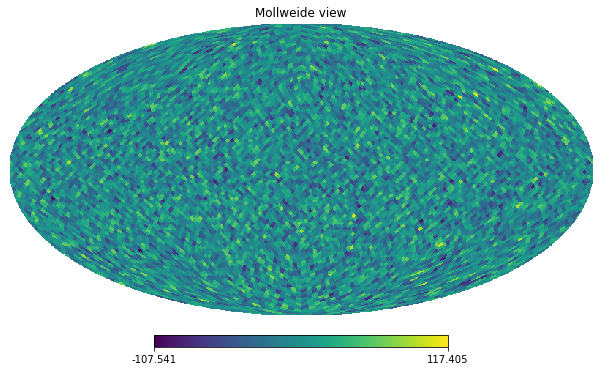

In [7]:
nside = 32
npix = 12*nside**2
lmax = 3*nside-1
sampling_rate = 10 #hz
baseline_length_seconds = 3 #seconds
baseline_length = baseline_length_seconds * sampling_rate
cl = np.ones(lmax)
cl[:2] = 0
m = hp.synfast(cl, nside)
hp.mollview(m)

In [8]:
pixels_lr, pixels_ud = create_pixels()
#Combine into 1 observation
pixels = np.concatenate([pixels_lr, pixels_ud])
nsamp = len(pixels)

In [9]:
signal = m[pixels]

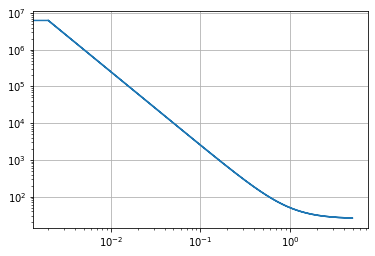

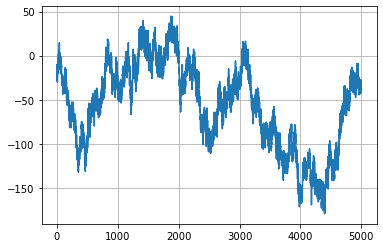

In [10]:
reload(lib)
noise = lib.generate_noise(nsamp, 1/sampling_rate, fknee=1, alpha=2, sigma=5)
plt.plot(np.arange(nsamp), noise)
plt.grid()

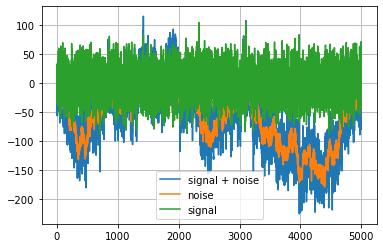

In [11]:
y = signal + noise
plt.plot(y, label='signal + noise')
plt.plot(noise, label='noise')
plt.plot(signal, label='signal')
plt.legend()
plt.grid()

In [12]:
mapmaker = Mapmaker(pixels, nside, baseline_length, verbose=False)
a = mapmaker.solve(y)

Residual: 1.8661138976544973e-13 in 32 iterations


/tmp/ipykernel_48765/297539256.py:11: RuntimeWarning: invalid value encountered in true_divide
  proj = P(PT(y, pixels, npix)/PTP(pixels, npix), pixels)


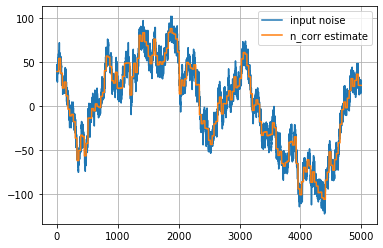

In [13]:
plt.plot(noise - np.mean(noise), label='input noise')
plt.plot(F(a, baseline_length) - np.mean(F(a, baseline_length)), label='n_corr estimate')
plt.grid()
plt.legend()

In [14]:
m_destripe = PT(y - F(a, baseline_length), pixels, npix)/PTP(pixels, npix) #Destriping solution

#remove monopole
m_destripe -= np.nanmean(m_destripe)

/tmp/ipykernel_48765/14277513.py:1: RuntimeWarning: invalid value encountered in true_divide
  m_destripe = PT(y - F(a, baseline_length), pixels, npix)/PTP(pixels, npix) #Destriping solution


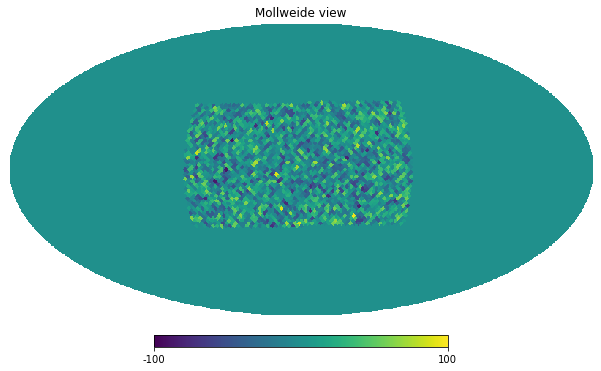

In [18]:
m_destripe[np.isnan(m_destripe)] = 0
hp.mollview(m_destripe, min=-100, max=100)

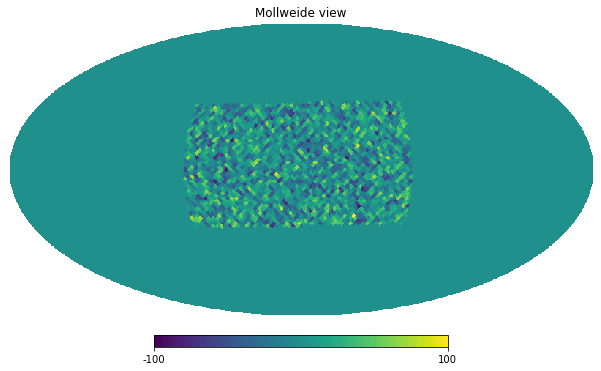

In [17]:
m[np.isnan(m_destripe)] = 0
hp.mollview(m, min=-100, max=100)

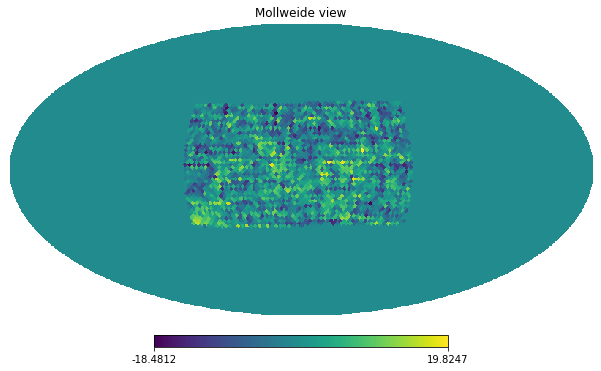

In [19]:
hp.mollview(m-m_destripe)